In [1]:
#!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
#!pip install adabelief-tf==0.2.0

In [3]:
from adabelief_tf import AdaBeliefOptimizer
Adam_optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-7, rectify=True)

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.0)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

In [5]:
#!git clone https://github.com/bearpaw/clothing-co-parsing.git

In [6]:
images = []
for i in range(1,1001):
    url = './clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

In [7]:
masks = []
for i in range(1,1001):
    url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [8]:
len(images), len(masks)

(1000, 1000)

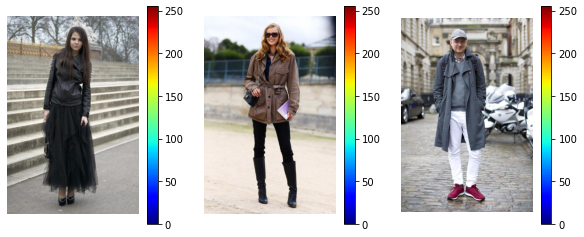

In [9]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [10]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

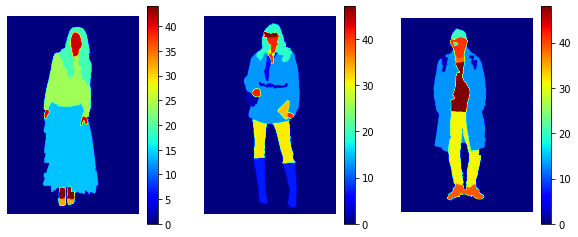

In [11]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [12]:
base = keras.applications.DenseNet121(input_shape=[128,128,3], 
                                      include_top=False, 
                                      weights='imagenet')

In [13]:
len(base.layers)

427

In [14]:
skip_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

In [15]:
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [16]:
downstack = keras.Model(inputs=base.input,
                       outputs=skip_outputs)
downstack.trainable = False

In [17]:
# Four upstack layers for upsampling sizes 
# 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3),
          pix2pix.upsample(64,3)]

In [18]:
upstack[0].layers

In [19]:
inputs = keras.layers.Input(shape=[128,128,3])

down = downstack(inputs)
out = down[-1]

skips = reversed(down[:-1])

for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])
    
out = keras.layers.Conv2DTranspose(59, 3,strides=2,padding='same',)(out)
unet = keras.Model(inputs=inputs, outputs=out)

In [20]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (128,128))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask

In [21]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1000, 1000)

In [22]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

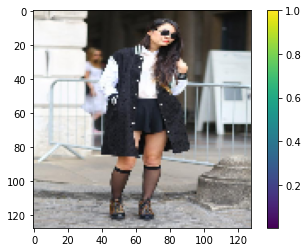

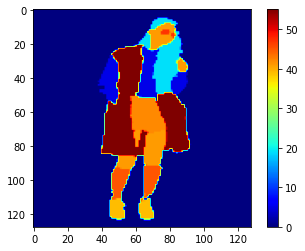

In [23]:
plt.imshow(X[0])
plt.colorbar()
plt.show()

plt.imshow(tf.squeeze(y[0]), cmap='jet')
plt.colorbar()
plt.show()

##Functions for augmentation

In [24]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.2)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, 0)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.6)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.6)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [25]:
from sklearn.model_selection import train_test_split

train_X, val_X,train_y, val_y = train_test_split(X,y, test_size=0.3, random_state=69)
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [26]:

train = tf.data.Dataset.zip((train_X, train_y)).repeat()
val = tf.data.Dataset.zip((val_X, val_y)).repeat()

a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [27]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 100

STEPS_PER_EPOCH = 400//BATCH
VALIDATION_STEPS = 300//BATCH

In [28]:
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

##Check for Model and Data compatibility

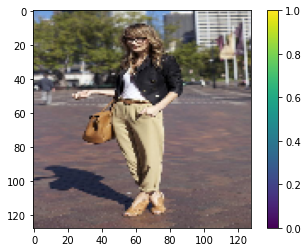

In [29]:
example = next(iter(train))
preds = unet(example[0])
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

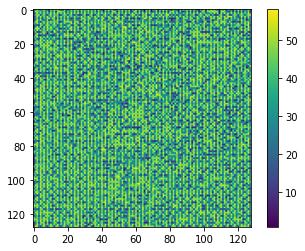

In [30]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(tf.squeeze(pred_mask[0]))
plt.colorbar()

In [31]:
unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=Adam_optimizer,
    metrics=['accuracy']
)

##Training

In [ ]:
hist = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=10, verbose=1)

##Prediction

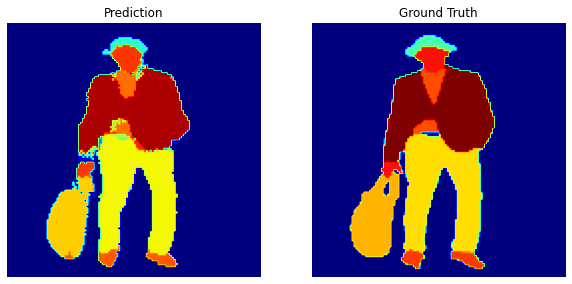

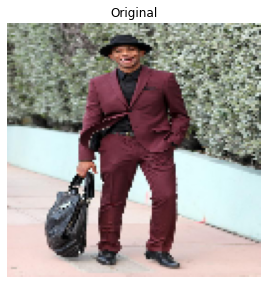

In [75]:
plt.figure(figsize=(10,5))
new_iter = iter(val)
first_batch = next(new_iter)
second_batch= next(new_iter)
third_batch = next(new_iter)
fourth_batch = next(new_iter)
img, mask = third_batch
pred = unet.predict(img)

for i in pred:
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(tf.squeeze(i),cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break

plt.subplot(122)
plt.imshow(tf.squeeze(mask[0]), cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(tf.squeeze(img[0]), cmap='jet')
plt.axis('off')
plt.title('Original')
plt.show()

##Performance Curves

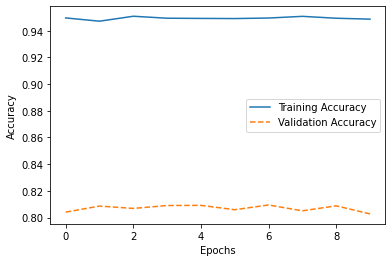

In [77]:
history = hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']

plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()